In [1]:
import torch
import torch.nn as nn
import numpy as np
import normflows as nf
import numpy as np

import Train

from matplotlib import pyplot as plt
from tqdm import tqdm
from Base import DirichletProcessMixture, DPGM
from HeavyTarget import AsymmetricStudentT, MixtureTarget, MultStudentT




In [11]:
#set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [12]:
# set seed.
torch.manual_seed(0)
np.random.seed(0)


dimension = 1
#base = nf.distributions.GaussianMixture(n_modes=2, dim=dimension, loc=[[3],[-3]], weights=[0.1, 0.9])
#base = DPGM(shape=dimension, T=2)
base = DirichletProcessMixture(shape=dimension, T=2)

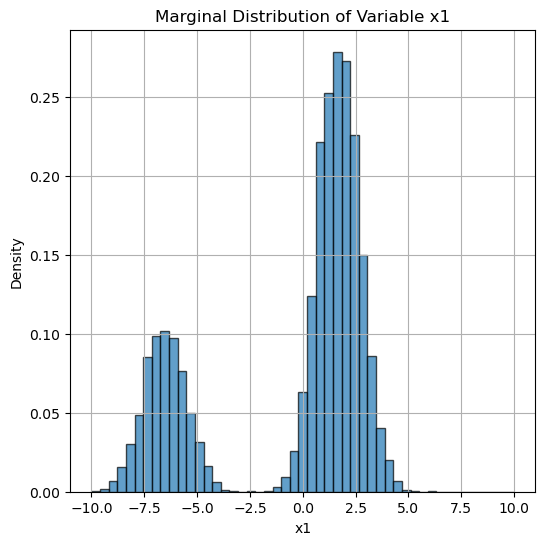

In [14]:
Train.plot_samples(q0, two_d=True, min=-10, max=10)

In [15]:
Train.print_model_parameters(q0)

--- stick-breaking params ---
  a: [1.0000]
  b: [2.7183]
  pi (expected): [0.2689, 0.7311]

--- component #0 (GaussianDistribution) ---
  mean: [-6.5364]
  scale: [1.0000]

--- component #1 (GaussianDistribution) ---
  mean: [1.7053]
  scale: [1.0000]



In [6]:
'''
target1 = AsymmetricStudentT(df=(30,30), mean=(0,5))
target2 = AsymmetricStudentT(df=(30,30), mean=(2,-4))
target3 = nf.distributions.DiagGaussian(shape=2)
target = MixtureTarget(target1, target2, weight=(0.5, 0.5))
target = MixtureTarget(target, target3, weight=(0.5, 0.5))
'''
'''
target = AsymmetricStudentT(df=3)
'''
target1 = MultStudentT(df = 50, mean=[3])
target2 = MultStudentT(df = 50, mean=[-3])
target = MixtureTarget(target1, target2, weight=(0.3, 0.7))



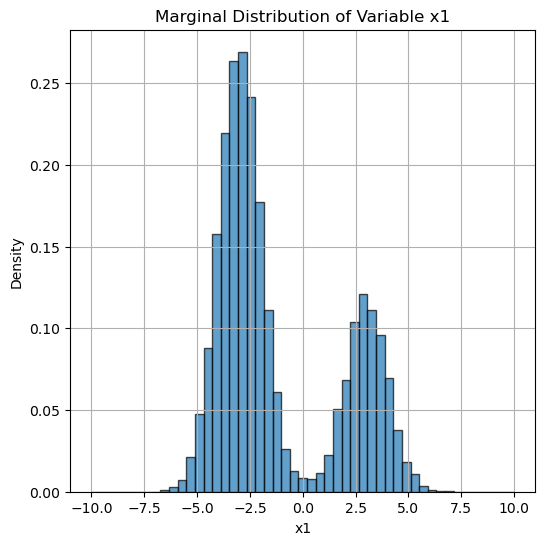

In [7]:
Train.plot_samples(target, two_d=True, min=-10, max=10)

In [8]:
import torch
import torch.nn.functional as F
from torch.distributions import Beta
from tqdm import tqdm
import numpy as np

# 1) 정의: 비모수 변분분포
q0 = base
# target 은 up-to-constant log 밀도를 반환하는 객체
# class Target:
#     def log_prob(self, theta): ... 

# 2) 옵티마이저
optimizer = torch.optim.Adam(q0.parameters(), lr=5e-3, weight_decay=1e-5)

loss_hist = []

# 3) 학습 루프
for it in tqdm(range(4000)):
    optimizer.zero_grad()
    # (i) 재파라미터 표본: θ, 그리고 log q(θ|mode)+log q(mode|V)
    theta, log_q_tc = q0.forward(num_samples=1024)
    # theta: [1024, 1], log_q_tc: [1024]

    # (ii) 표적 사후(log p) 계산
    log_p = target.log_prob(theta).view(-1)       # [1024]

    # (iii) 분석적 E_q[log q(V)] 항
    a = torch.exp(q0.log_a)                       # [T-1]
    b = torch.exp(q0.log_b)
    # E_q[log Beta(V_k; a_k,b_k)] = log B(a,b)⁻¹ + (a-1)ψ(a) + (b-1)ψ(b) - (a+b-2)ψ(a+b)
    term  = torch.lgamma(a+b) - torch.lgamma(a) - torch.lgamma(b)
    term += (a-1)*(torch.digamma(a)) + (b-1)*(torch.digamma(b))
    term -= (a+b-2)*torch.digamma(a+b)
    log_qV = term.sum()                           # scalar

    # (iv) 전체 변분 로그밀도
    #     log q(θ,c,V) = [log_q_tc] + [log_qV]
    #               (pathwise)   + (analytic)
    log_q_total = log_q_tc + log_qV              # broadcast, shape [1024]

    # (v) reverse-KL loss = E_q[log q] - E_q[log p]
    loss = torch.mean(log_q_total) - torch.mean(log_p)

    # backprop & step
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())
    if it % 300 == 0:
        print(f"Iter {it} → loss {loss.item():.3f}")

# 결과: q0.log_a, q0.log_b, q0.means, q0.log_scale 등에 gradient 가 흘러 학습됨
# 히스토그램 등으로 최종 θ 샘플과 target 분포를 비교해 보세요.


  6%|▌         | 249/4000 [00:00<00:02, 1254.52it/s]

Iter 0 → loss 1.597


 13%|█▎        | 503/4000 [00:00<00:02, 1260.29it/s]

Iter 300 → loss 0.346


 19%|█▉        | 753/4000 [00:00<00:02, 1203.88it/s]

Iter 600 → loss 0.090


 28%|██▊       | 1132/4000 [00:00<00:02, 1245.80it/s]

Iter 900 → loss 0.107


 35%|███▍      | 1385/4000 [00:01<00:02, 1254.50it/s]

Iter 1200 → loss 0.084


 41%|████      | 1637/4000 [00:01<00:01, 1251.21it/s]

Iter 1500 → loss 0.075


 51%|█████     | 2021/4000 [00:01<00:01, 1257.65it/s]

Iter 1800 → loss 0.082


 57%|█████▋    | 2273/4000 [00:01<00:01, 1242.36it/s]

Iter 2100 → loss 0.057


 66%|██████▌   | 2637/4000 [00:02<00:01, 1062.83it/s]

Iter 2400 → loss 0.095


 72%|███████▏  | 2880/4000 [00:02<00:00, 1132.75it/s]

Iter 2700 → loss 0.072


 78%|███████▊  | 3122/4000 [00:02<00:00, 1167.12it/s]

Iter 3000 → loss 0.096


 87%|████████▋ | 3492/4000 [00:02<00:00, 1178.09it/s]

Iter 3300 → loss 0.079


 93%|█████████▎| 3735/4000 [00:03<00:00, 1194.33it/s]

Iter 3600 → loss 0.082


100%|██████████| 4000/4000 [00:03<00:00, 1188.77it/s]

Iter 3900 → loss 0.095


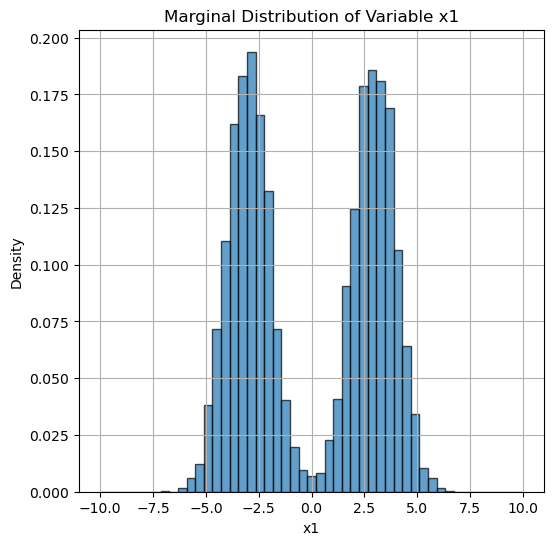

In [9]:
Train.plot_samples(base, two_d=True, min=-10, max=10)

In [8]:
K = 2
latent_size = dimension
hidden_units = 64
hidden_layers = 3

flows = []

for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    #flows += [nf.flows.LULinearPermute(latent_size, identity_init=True)]

model = nf.NormalizingFlow(base, flows, p=target)
model = model.to(torch.float32)

  0%|          | 0/8000 [00:00<?, ?it/s]

Iteration 0, loss: 0.14494800567626953


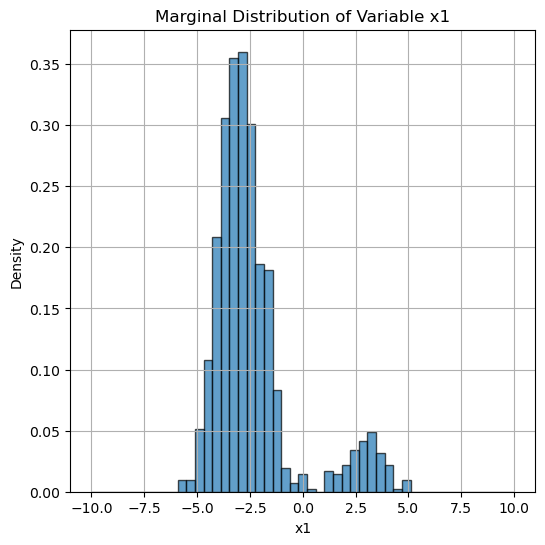

 12%|█▏        | 999/8000 [00:02<00:17, 411.77it/s]

Iteration 1000, loss: 0.21133530139923096


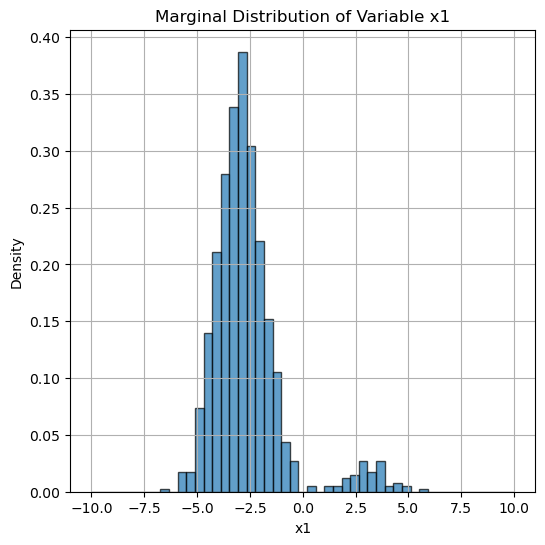

 25%|██▍       | 1994/8000 [00:05<00:14, 419.70it/s]

Iteration 2000, loss: 0.1376492977142334


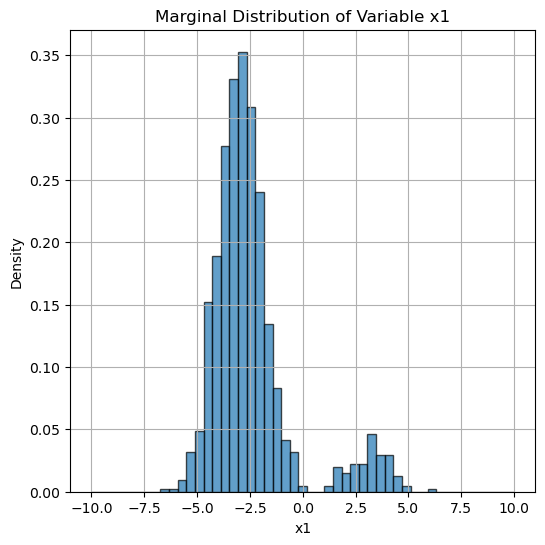

 37%|███▋      | 2998/8000 [00:07<00:12, 416.38it/s]

Iteration 3000, loss: 0.16143357753753662


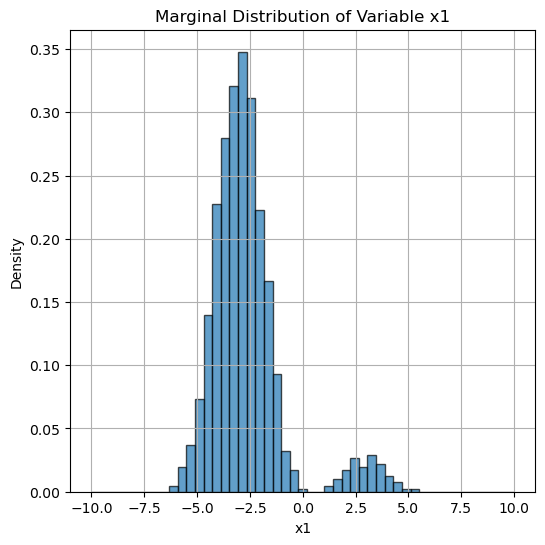

 50%|████▉     | 3973/8000 [00:10<00:09, 402.74it/s]

Iteration 4000, loss: 0.18365061283111572


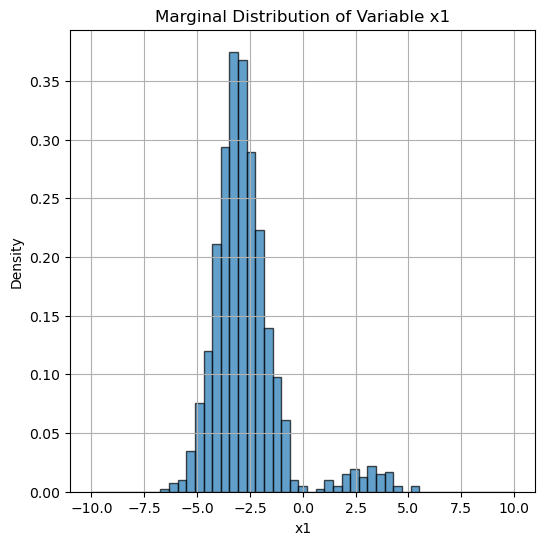

 62%|██████▏   | 4959/8000 [00:12<00:07, 392.83it/s]

Iteration 5000, loss: 0.1805487871170044


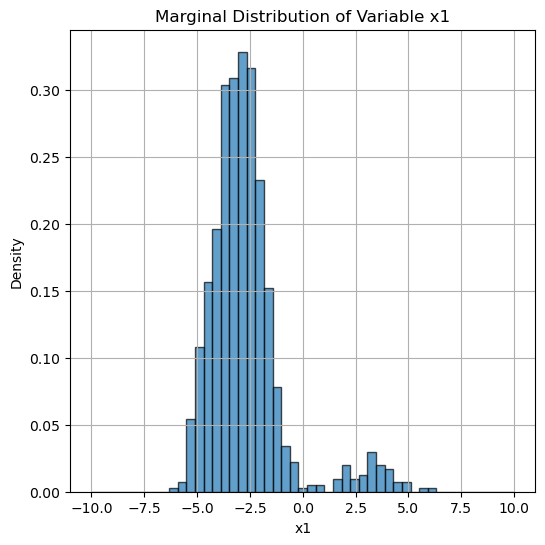

 75%|███████▍  | 5985/8000 [00:15<00:05, 395.84it/s]

Iteration 6000, loss: 0.15836811065673828


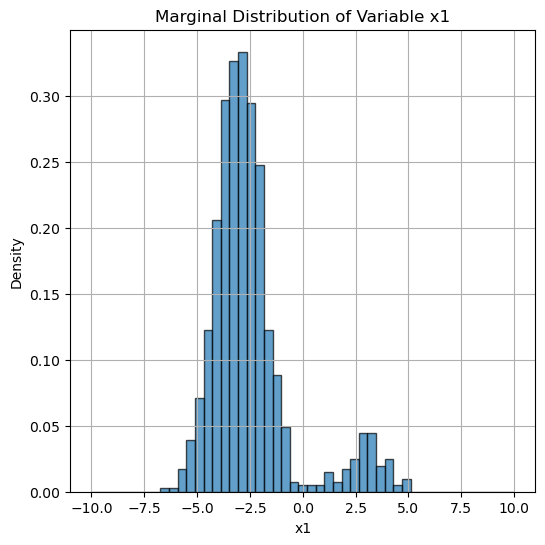

 87%|████████▋ | 6993/8000 [00:18<00:02, 410.16it/s]

Iteration 7000, loss: 0.17546236515045166


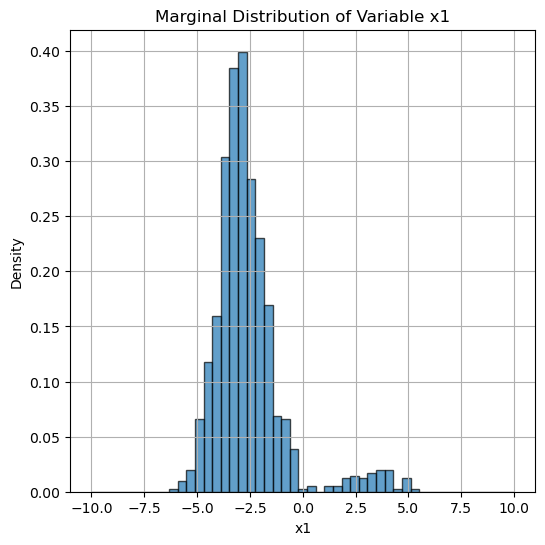

100%|██████████| 8000/8000 [00:20<00:00, 381.25it/s]


In [9]:
max_iter = 8000
lr = 5e-3
num_samples = 2**10
show_iter = 1000
weight_decay = 1e-5
freeze_flow =False # freeze flow parameters
freeze_ratio = 0.5 # do not update flow parameters. 

loss_hist = np.array([])

# Freeze the flow parameters
for param in model.flows.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples)
    if it == int(max_iter * freeze_ratio):
        if freeze_flow:
            for param in model.flows.parameters():
                param.requires_grad = True
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward(retain_graph=True)
        optimizer.step()
        if it % show_iter == 0:
            print(f"Iteration {it}, loss: {loss.item()}")
            Train.plot_samples(model, num_samples=1000, two_d=True, min=-10, max=10)
        
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

In [10]:
'''
# Training parameters
max_iter = 4000
lr = 5e-3
weight_decay = 1e-5
freeze_ratio = 0.5 # do not update flow parameters. 
update_beta_ratio = 0.3
freeze_flow = True
num_samples = 2**10
show_iter = 500
loss_hist = np.array([])

# Freeze the flow parameters
for param in model.flows.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward(retain_graph=True)
        optimizer.step()
        if it < max_iter * update_beta_ratio:
            model.q0.update_beta()
    if it == int(max_iter * freeze_ratio):
        if freeze_flow:
            for param in model.flows.parameters():
                param.requires_grad = True
    if it == int(max_iter * update_beta_ratio):
        model.q0.log_eta.requires_grad = False
        #### tail index estimation and update base distribution ####
        
        model.eval()
        new_base = DirichletProcessPoductTMixture(shape=dimension, T=model.q0.T, train_eta=False)
        new_base.log_eta.data = model.q0.log_eta.data.clone() 
        new_base.means.data = model.q0.means.data.clone()  
        new_base.log_scale.data = model.q0.log_scale.data.clone()
        model.q0 = new_base

        with torch.no_grad():
            weights = torch.softmax(model.q0.log_pi, dim=0)           # (T,)
            means   = model.q0.means.clone()                          # (T, d)
            scales  = model.q0.log_scale.exp().clone()               # (T, d)
            T, d    = means.shape

        # --- 2) For each component t and each dimension, estimate tail index nu_hat ---
        dfs = []
        nu_hats_all = []
        global_mean = Train.compute_global_mean(model.q0)
        for t in range(T):
            # returns ndarray or list of length d
            nu_hat_vec = Train.estimate_tail_indices_t(
                mean=means[t].detach().cpu().numpy(),
                scale=scales.detach().cpu().numpy(),
                df=2.0,
                global_mean=global_mean,
                target=model.p,
                num_samples=3000,
                k=2990
            )
            # to torch.Tensor on right device & dtype
            nu_hats_all.append(torch.tensor(nu_hat_vec, device=means.device, dtype=new_base.df.dtype))
        print(nu_hats_all)
        # stack into (T, d)
        nu_hats_tensor = torch.stack(nu_hats_all)  # shape: (T, d)

        # clamp out-of-bounds to 30
        df_new = torch.where(
            (nu_hats_tensor >= 1.0) & (nu_hats_tensor <= 30.0),
            nu_hats_tensor,
            torch.full_like(nu_hats_tensor, 30.0)
        )  # (T, d)

        # reshape into (T, *shape) matching new_base.df
        df_buffer = df_new.view_as(new_base.df)

        # copy into the df buffer
        new_base.df.copy_(df_buffer)

        model.train() # back to training mode
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        if dimension==2:
            grid_size = 200
            xx, yy = torch.meshgrid(torch.linspace(-20, 20, grid_size), torch.linspace(-20, 20, grid_size))
            zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
            
            model.eval()
            log_prob = model.log_prob(zz)
            prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
            prob[torch.isnan(prob)] = 0

            # 현재 eta 값 계산 (scalar)
            eta_value = torch.exp(model.q0.log_eta).item()
            print(f"Iteration {it+1}, eta: {eta_value:.4f}")
            model.train()

            plt.figure(figsize=(5, 5))
            plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
            plt.gca().set_aspect('equal', 'box')
            plt.show()
        else:
            model.eval()  # 평가 모드 전환

            eta_value = torch.exp(model.q0.log_eta).item()
            print(f"Iteration {it+1}, eta: {eta_value:.4f}")
            # 샘플링
            samples, _ = model.sample(num_samples=1000)
            x1 = samples[:, 0].detach().cpu().numpy()

            # 히스토그램 그리기
            bins = np.arange(38, 100, 1)
            plt.figure(figsize=(6, 4))
            plt.hist(x1, bins=bins, density=True, alpha=0.7, edgecolor='black')
            plt.title(f'Iteration {it+1}: Marginal Distribution of x₁')
            plt.xlabel('x₁')
            plt.ylabel('Density')
            plt.grid(True)
            plt.show()
            print(loss.to('cpu').data.numpy())
            model.train()  # 다시 학습 모드로 전환
'''

'\n# Training parameters\nmax_iter = 4000\nlr = 5e-3\nweight_decay = 1e-5\nfreeze_ratio = 0.5 # do not update flow parameters. \nupdate_beta_ratio = 0.3\nfreeze_flow = True\nnum_samples = 2**10\nshow_iter = 500\nloss_hist = np.array([])\n\n# Freeze the flow parameters\nfor param in model.flows.parameters():\n    param.requires_grad = False\n\noptimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)\n\nfor it in tqdm(range(max_iter)):\n    optimizer.zero_grad()\n    loss = model.reverse_kld(num_samples)\n\n    # Do backprop and optimizer step\n    if ~(torch.isnan(loss) | torch.isinf(loss)):\n        loss.backward(retain_graph=True)\n        optimizer.step()\n        if it < max_iter * update_beta_ratio:\n            model.q0.update_beta()\n    if it == int(max_iter * freeze_ratio):\n        if freeze_flow:\n            for param in model.flows.parameters():\n                param.requires_grad = True\n    if it == int(max_iter * update_beta_ratio):\n        mo

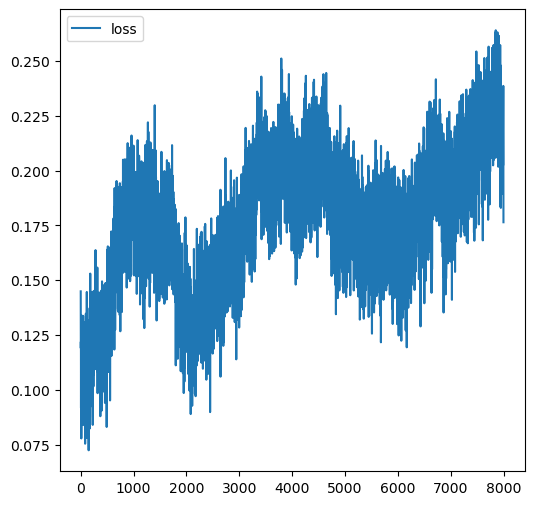

In [11]:
plt.figure(figsize=(6, 6))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

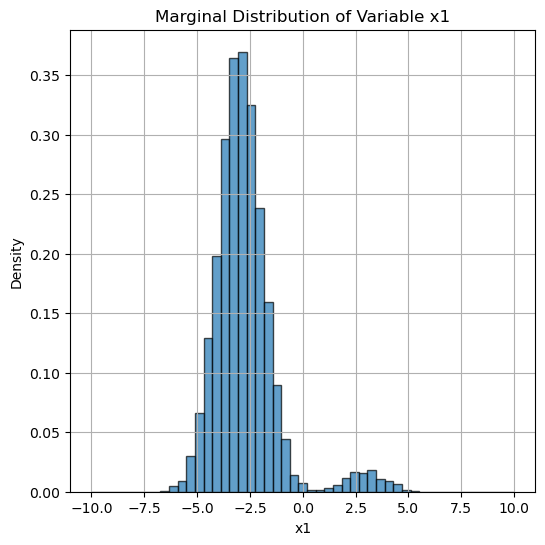

In [12]:
Train.plot_samples(model, min=-10, max=10)

In [13]:
Train.print_model_parameters(model.q0)
torch.softmax(model.q0.weight_scores,1)

--- component #0 (GaussianMixture) ---
  loc: [3.0045, -2.9821]
  scale: [0.9700, 1.0291]
  weight_scores: [-2.6791, 0.3907]



tensor([[0.0444, 0.9556]], grad_fn=<SoftmaxBackward0>)

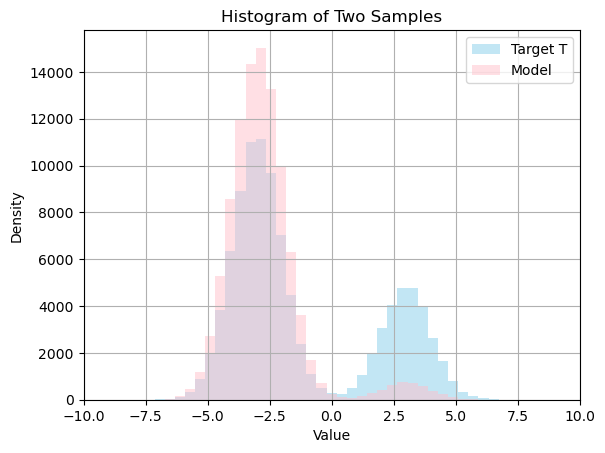

In [14]:
marginal = 1
s1 = target.sample(num_samples=100000).cpu().detach().numpy()[:, marginal-1]
s2 = model.q0.forward(100000)[0].cpu().detach().numpy()[:, marginal-1]
s3 = model.sample(100000)[0].detach().numpy()[:, marginal-1]

min = -10
max = 10
bins = 50

# 히스토그램 그리기
plt.hist(s1, bins=np.linspace(min, max, bins), alpha=0.5, label='Target T', color='skyblue', density=False)
#plt.hist(s2, bins=np.linspace(min, max, bins), alpha=0.5, label='Base Mixture', color='orange', density=False)
plt.hist(s3, bins=np.linspace(min, max, bins), alpha=0.5, label='Model', color='pink', density=False)

# 라벨 및 범례
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Two Samples')
plt.legend()
plt.xlim(min,max)
plt.grid(True)
plt.show()

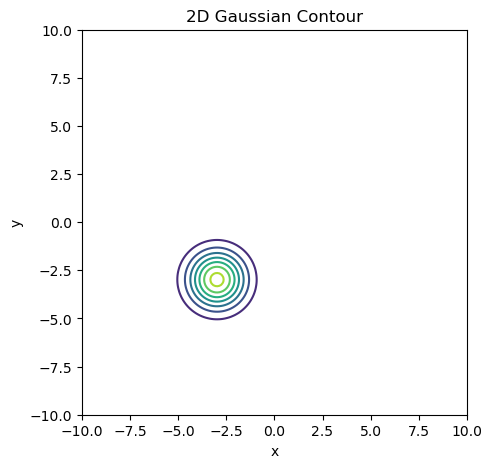

In [15]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Grid 설정
grid_size = 200
x = torch.linspace(-10, 10, grid_size)
y = torch.linspace(-10, 10, grid_size)
xx, yy = torch.meshgrid(x, y, indexing='xy')

# 위치 벡터 생성
pos = torch.stack([xx, yy], dim=-1)  # shape: (grid_size, grid_size, 2)

# 2D 정규분포 정의
dist = MultivariateNormal(torch.zeros(2), torch.eye(2))

# log_prob 계산 후 확률로 변환
zz = pos.view(-1, 2)
log_prob = base.log_prob(zz).view(grid_size, grid_size)
prob = torch.exp(log_prob)

# 등고선 그리기
plt.figure(figsize=(5, 5))
CS = plt.contour(xx.detach().numpy(), yy.detach().numpy(), prob.detach().numpy())
#plt.clabel(CS, inline=1, fontsize=10)
plt.gca().set_aspect('equal', 'box')
plt.title('2D Gaussian Contour')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
